## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection  import cross_val_score


from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploratory data analysis

In [4]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#observe the different feature type present in the data
df.shape


(284807, 31)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Insight:**
* Since the data is PCA transformed all features are expected tobe normally distributed. The data does not have any null value. Each feature has 284807 observations.
* The datatype of the 'Class' variable is int. Since we know that the Class vaiable should be categorical (0: non fraud & 1:fraud), we must change the datatype.

In [6]:
#Changing the data type of Class

df['Class'] = df['Class'].astype('category')

#Renaming the classes
df['Class'] = df['Class'].cat.rename_categories({1:'Fraudulent',0:'Non_Fraudulent'})

df['Class']

0         Non_Fraudulent
1         Non_Fraudulent
2         Non_Fraudulent
3         Non_Fraudulent
4         Non_Fraudulent
               ...      
284802    Non_Fraudulent
284803    Non_Fraudulent
284804    Non_Fraudulent
284805    Non_Fraudulent
284806    Non_Fraudulent
Name: Class, Length: 284807, dtype: category
Categories (2, object): [Non_Fraudulent, Fraudulent]

Here we will observe the distribution of our classes

In [7]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
print(normal_share)
fraud_share=classes[1]/df['Class'].count()*100
print(fraud_share)

99.82725143693798
0.1727485630620034


In [8]:
#Creating a df for percentage of each class
class_share = {'Class':['fraudulent','non_fraudulent'],'Percentage':[fraud_share,normal_share]}
class_share = pd.DataFrame(class_share)
class_share.head()

,Class,Percentage
0,fraudulent,0.172749
1,non_fraudulent,99.827251


The data is imbalanced. Only 0.172% of total cases are positive. 

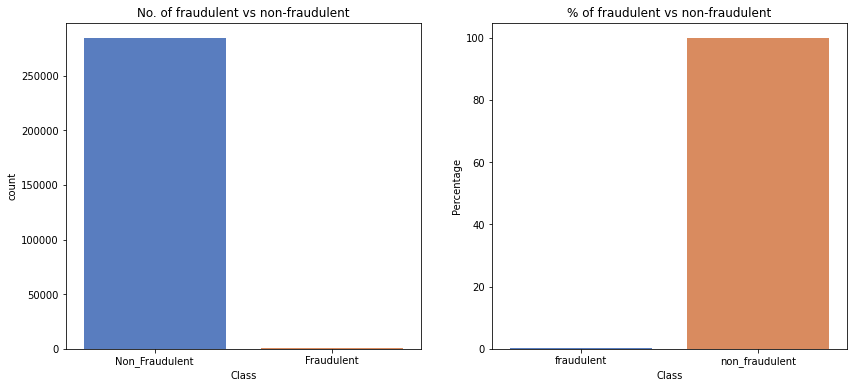

In [0]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
sns.set_palette("muted")
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.countplot('Class',data=df)
plt.title('No. of fraudulent vs non-fraudulent')

plt.subplot(122)
sns.barplot(x='Class', y='Percentage',data=class_share)
plt.title('% of fraudulent vs non-fraudulent')
plt.show()


The no. of fraudulent cases are quite insignificant compared to the non-fraudulent cases. This is a highly unbalnced dataset.

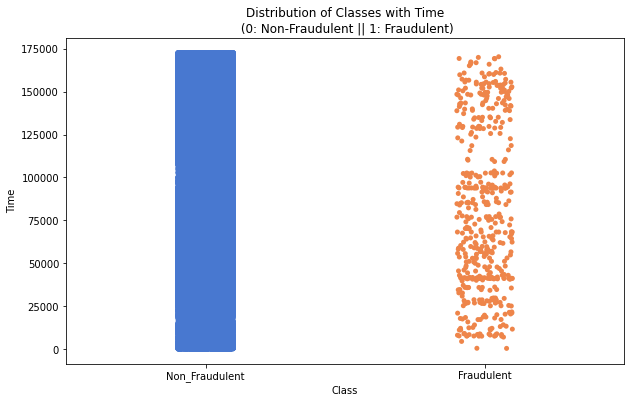

In [0]:
# Create a scatter plot to observe the distribution of classes with time
#sns.set_palette("muted")
plt.figure(figsize=(10,6))
sns.stripplot(x= 'Class', y= 'Time',data=df)
plt.title('Distribution of Classes with Time\n (0: Non-Fraudulent || 1: Fraudulent)')
plt.show()


**Insight:**
*   From the above plot we observe that there isn't any
particular time interval at which fraudulent transactions happen. It can happen at any time. 
* The Time column is evenly distributed for fraudulent transactions and doesn't seem to have any role in deciding whether a transaction is fraud or not.

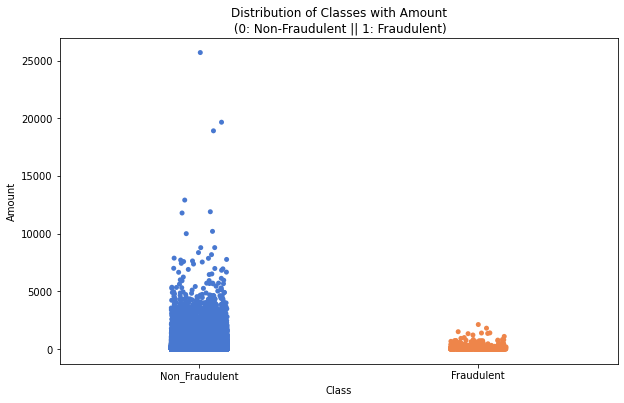

In [0]:
# Create a scatter plot to observe the distribution of classes with Amount
plt.figure(figsize=(10,6))
sns.stripplot(x= 'Class', y= 'Amount',data=df)
plt.title('Distribution of Classes with Amount\n (0: Non-Fraudulent || 1: Fraudulent)')
plt.show()

**Insight:** 

*   The fraudulent transactions do not have any high amount transactions. The maximum amount for a fraudulent transaction is somewhere around $2500. 
 



In [9]:
# Drop unnecessary columns
# Dropping the column 'Time' since it does not have any impact on deciding a fraud transaction

df=df.drop('Time',axis=1)
df.shape

(284807, 30)

### Splitting the data into train & test data

In [0]:
y= df.iloc[:,-1] #class variable
X = df.iloc[:,:-1]


In [0]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

#Using stratify=y so that proportion of each class is same in both train and test set

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [12]:
print('Total count for each class:\n', y.value_counts())
print("\nCount of each class in train data:\n",y_train.value_counts())
print("\nCount of each class in test data:\n",y_test.value_counts())

Total count for each class:
 Non_Fraudulent    284315
Fraudulent           492
Name: Class, dtype: int64

Count of each class in train data:
 Non_Fraudulent    227451
Fraudulent           394
Name: Class, dtype: int64

Count of each class in test data:
 Non_Fraudulent    56864
Fraudulent           98
Name: Class, dtype: int64


### Plotting the distribution of a variable

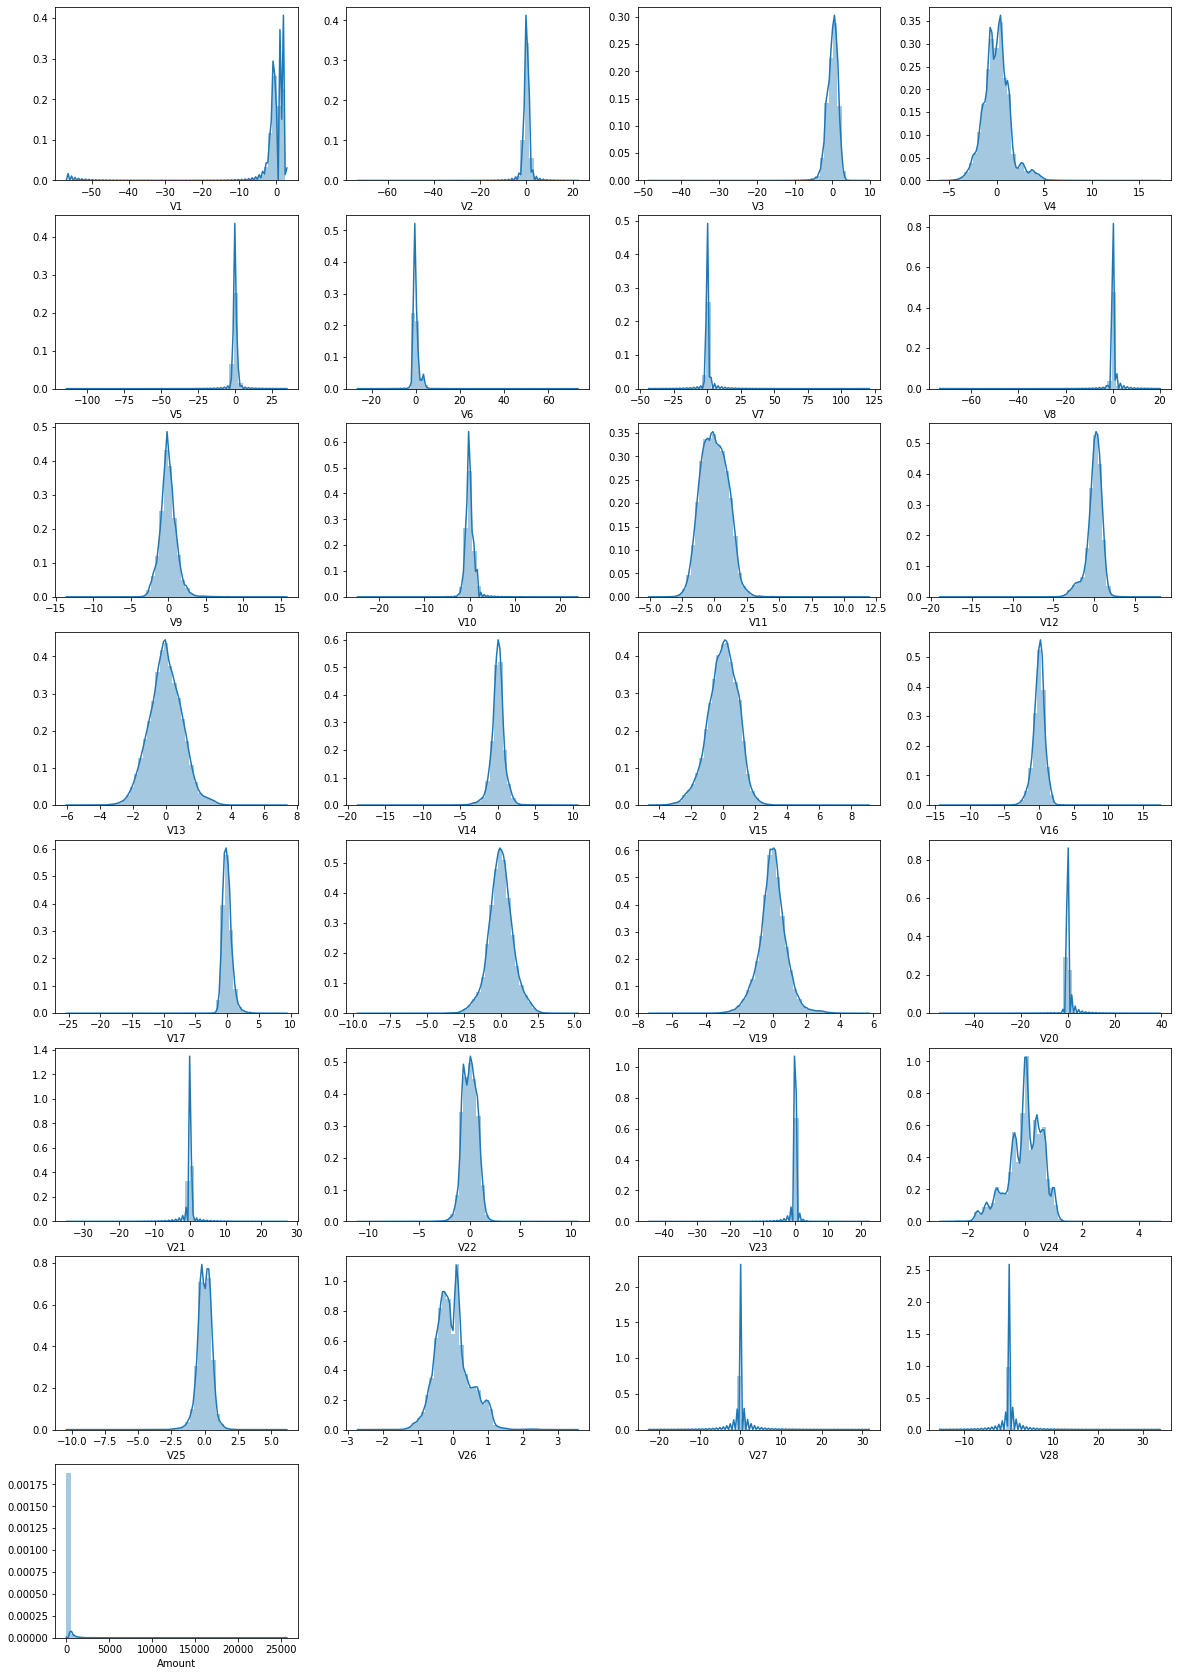

In [13]:
# plot the histogram of a variable from the dataset to see the skewness
# ploting distribution plot for all columns to check the skewness

#Loop for creating distplot.

collist = list(X_train.columns)

c = len(collist)
m = 1
n = 0

plt.figure(figsize=(20,30))

for i in collist:
  if m in range(1,c+1):
    plt.subplot(8,4,m)
    sns.distplot(X_train[X_train.columns[n]])
    m=m+1
    n=n+1

plt.show()




**Insight:**


*   We plotted distribution plots for all the variables and it is clearly that there are some variables which are skewed either towards left or right.
*   This means all variables are not normally distributed as expected even if this is a PCA transformed dataset.

* We must transform the data to remove the skewness.



### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [0]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
# Using ‘yeo-johnson’ method since it works with positive and negative values. It is used to improve normality or symmetry


from sklearn.preprocessing import power_transform

X_train = power_transform(X_train,method='yeo-johnson')
X_test = power_transform(X_test,method='yeo-johnson')

In [0]:
# Converting X_train & X_test back to dataframe
cols = X.columns

X_train = pd.DataFrame(X_train)
X_train.columns = cols

X_test = pd.DataFrame(X_test)
X_test.columns = cols


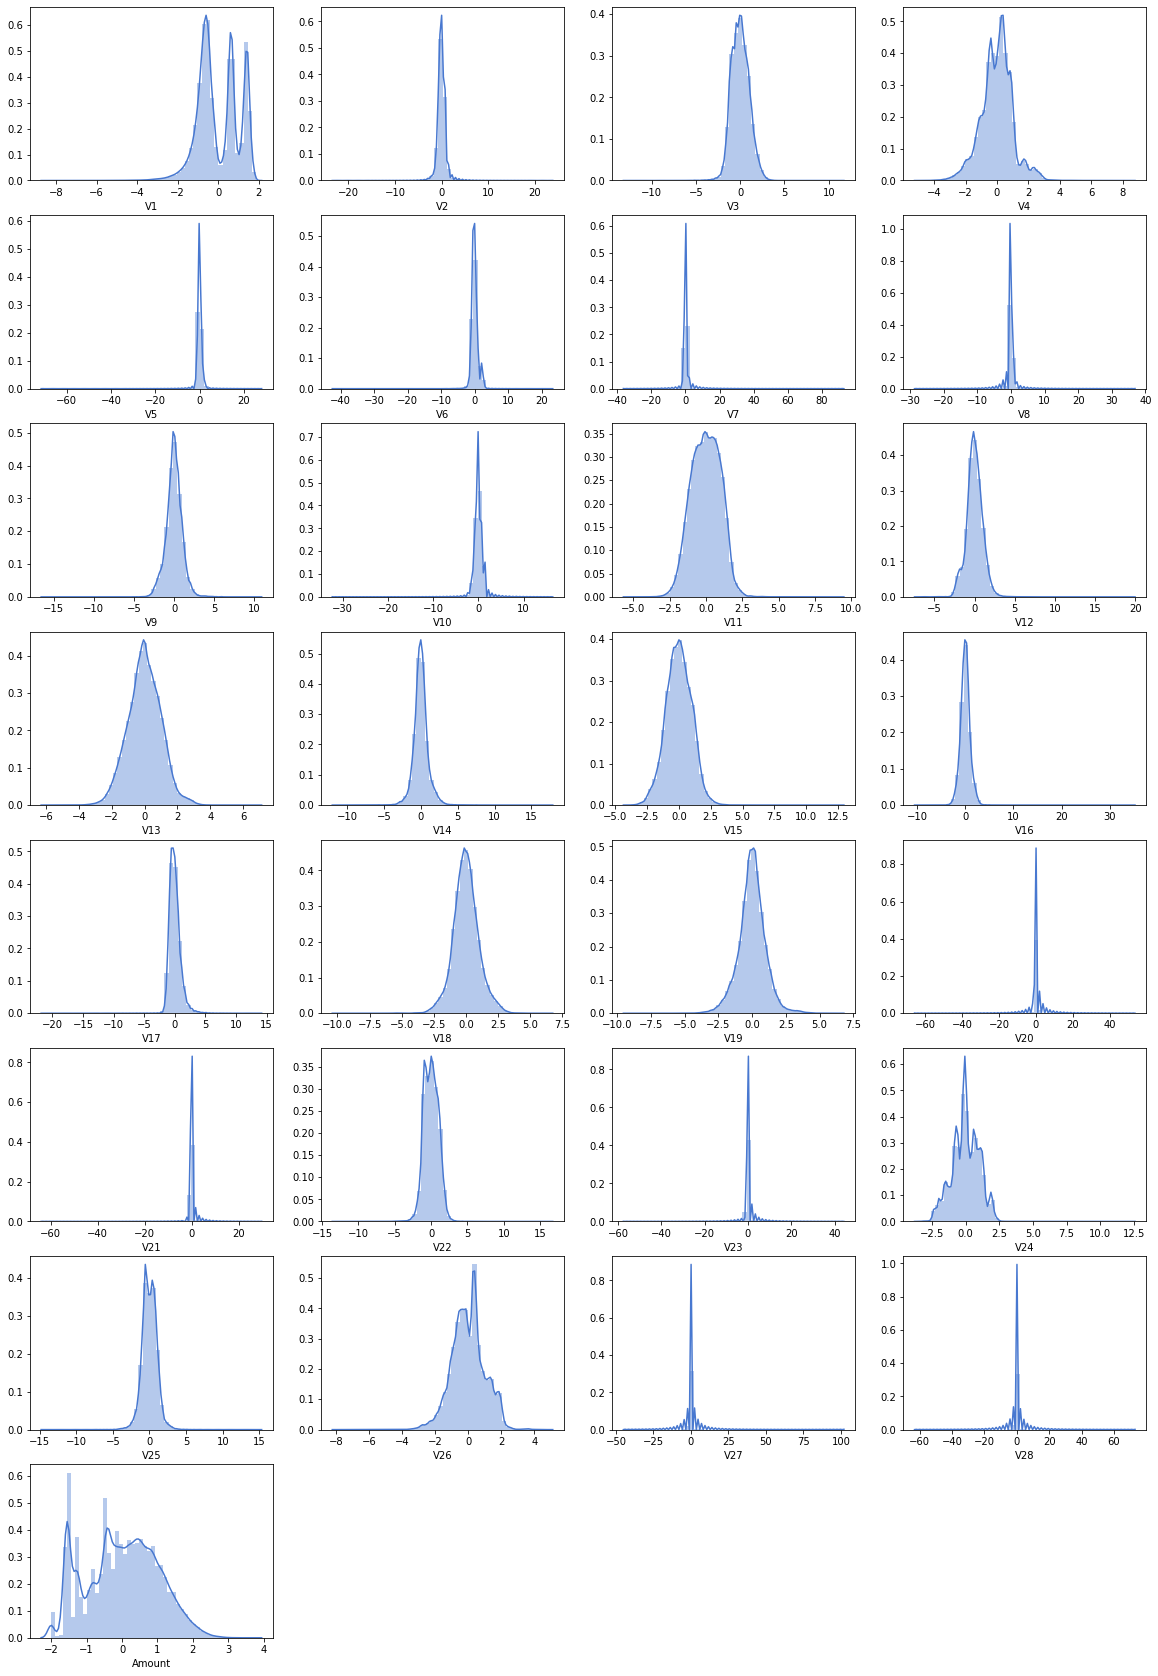

In [0]:
# plot the histogram of a variable from the dataset again to see the result 
# Plotting same set of variables as earlier to identify the difference.

#Loop for creating distplot.

collist = list(X_train.columns)

c = len(collist)
m = 1
n = 0

plt.figure(figsize=(20,30))

for i in collist:
  if m in range(1,c+1):
    plt.subplot(8,4,m)
    sns.distplot(X_train[X_train.columns[n]])
    m=m+1
    n=n+1

plt.show()



**Insight:**


*   After the Power transformation the variables are more gaussian like.
*   Changes in V1, V12, V26 and Amount coulmn are quite evident. Skewness has been removed to some extent.



### **Model performance parameter:**


*   We will use ROC curve and find AUC Score as the performance matrix for the models.
*  ROC curve meausres the performance of the model at different thresholds which will help us find the optimum threshold for the model.



In [0]:
# Function to plot ROC curve and classification score which will be used for each model

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

def plot_roc(fpr,tpr):
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='yellow', linestyle='--')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def clf_score(clf):
    prob = clf.predict_proba(X_test)
    prob = prob[:, 1]
    auc = roc_auc_score(y_test, prob)    
    print('AUC: %.2f' % auc)
    fpr, tpr, thresholds = roc_curve(y_test,prob, pos_label='Non_Fraudulent')
    plot_roc(fpr,tpr)
    predicted=clf.predict(X_test)
    report = classification_report(y_test, predicted)
    print(report)
    return auc


## Model Building on the imbalanced dataset


**Note**:
- Due to time constraint we have choosen few parameters to tune in each model.

- For cross validation, GridsearchCV and Stratified Kfold (cross_val_score) has been used.

### Logistic Regression

In [0]:
# Logistic Regression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression #import the package



In [0]:
num_C = [0.001,0.01,0.1,1,10,100] #--> list of values

for cv_num in num_C:
  clf = LogisticRegression(penalty='l2',C=cv_num,random_state = 0)
  clf.fit(X_train, y_train)
  print('C:', cv_num)
  print('Coefficient of each feature:', clf.coef_)
  print('Training accuracy:', clf.score(X_train, y_train))
  print('Test accuracy:', clf.score(X_test, y_test))
  print('')

C: 0.001
Coefficient of each feature: [[ 0.05827245 -0.03231278  0.15258413 -0.2303827  -0.03251785  0.04418223
   0.06092596  0.1053219   0.11901376  0.23577849 -0.17897772  0.23620764
   0.0429589   0.40046756  0.01684527  0.118289    0.11039617  0.00086577
   0.00221737 -0.01263307 -0.02883974 -0.03215089  0.03304381  0.02416244
   0.00155655 -0.01639014 -0.00758294  0.00107762  0.01629961]]
Training accuracy: 0.9990344313019817
Test accuracy: 0.9988939995084443

C: 0.01
Coefficient of each feature: [[ 0.15546705  0.08584789  0.26579153 -0.57537251 -0.01738138 -0.03487857
   0.11891721  0.19132465  0.16632621  0.22402918 -0.16014372  0.44675415
   0.14777179  0.65203773  0.11114447  0.20586739  0.02118281 -0.0613255
   0.05790786  0.00283988 -0.04986379 -0.1719924   0.0859131  -0.00722106
  -0.04617946 -0.0330326   0.05303884  0.03400267 -0.00360083]]
Training accuracy: 0.999223156092958
Test accuracy: 0.9990695551420246

C: 0.1
Coefficient of each feature: [[ 0.21452938  0.22263954



*   The best C value is the one for which the difference between train and test score is the least.
*   In our case the best value of C=0.1



In [0]:
#perform cross validation
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}  # l2 ridge

lsr = LogisticRegression()
clf_lsr_cv = GridSearchCV(lsr,grid,cv=3,scoring='roc_auc')
clf_lsr_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_lsr_cv.best_params_)
print("accuracy :",clf_lsr_cv.best_score_)

#perform hyperparameter tuning



#print the optimum value of hyperparameters

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.9803975962273005




*   Best parameters :  {'C': 0.01, 'penalty': 'l2'}




AUC: 0.98


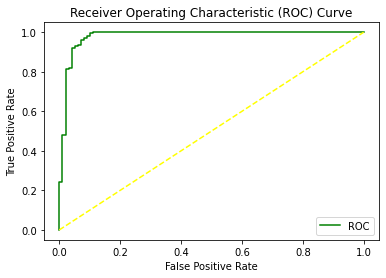

                precision    recall  f1-score   support

    Fraudulent       0.87      0.54      0.67        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.93      0.77      0.83     56962
  weighted avg       1.00      1.00      1.00     56962



0.9799370930139079

In [0]:
# Fitting the model with best parameters .

lsr_best = LogisticRegression(penalty='l2',C=0.01,random_state = 0)
lsr_clf = lsr_best.fit(X_train,y_train)
clf_score(lsr_clf)



*   The AUC score is 0.98 but the data is clearly overfitting due to the imbalanced data.




### KNN

In [17]:
#K-Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

# Taking only odd integers as K values to apply the majority rule. 
k_range = np.arange(1, 20, 2)
scores = [] #to store cross val score for each k
k_range

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])

In [0]:
# Finding the best k with stratified K-fold method. 
# We will use cv=3 in cross_val_score to specify the number of folds in the (Stratified)KFold.

for k in k_range:
  knn_clf = KNeighborsClassifier(n_neighbors=k)
  knn_clf.fit(X_train,y_train)
  score = cross_val_score(knn_clf, X_train, y_train, cv=3, n_jobs = -1)
  scores.append(score.mean())

#Storing the mean squared error to decide optimum k
mse = [1-x for x in scores]


In [0]:
scores

[0.999420658838955,
 0.9995084377922426,
 0.999460159261026,
 0.999433825915991,
 0.9993811584746722,
 0.9993723805388917,
 0.9993679916287898,
 0.9993504358728051,
 0.9993328800012439,
 0.9993065463672672]

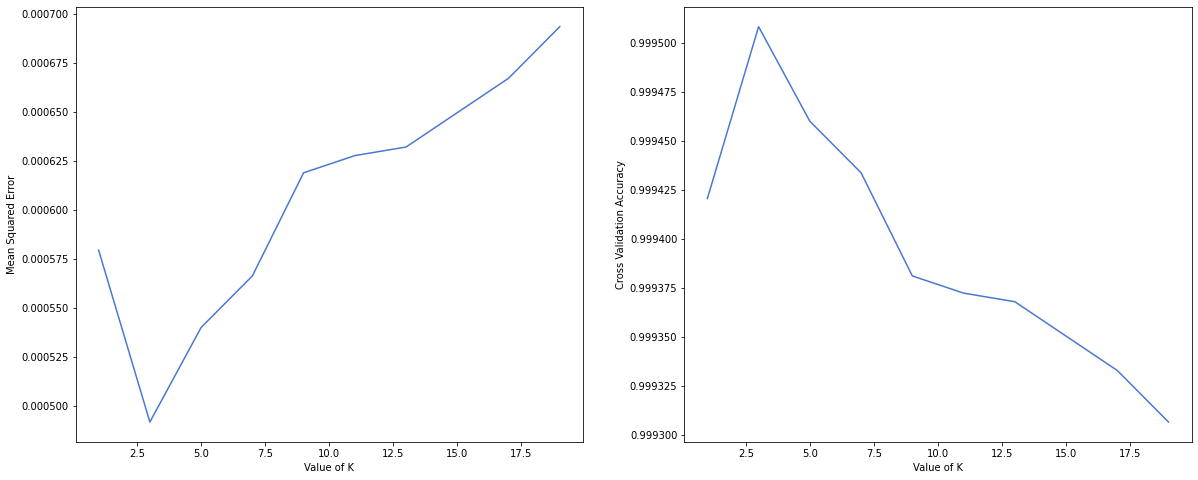

In [0]:
#Plotting a line plot to decide optimum value of K

plt.figure(figsize=(20,8))
plt.subplot(121)
sns.lineplot(k_range,mse,markers=True,dashes=False)
plt.xlabel("Value of K")
plt.ylabel("Mean Squared Error")
plt.subplot(122)
sns.lineplot(k_range,scores,markers=True,dashes=False)
plt.xlabel("Value of K")
plt.ylabel("Cross Validation Accuracy")

plt.show()





*   From the above plot optimum K value is 3 for KNN





In [0]:
#Fitting the best parameter to the model
# 3 fold cross validation with K=3

knn = KNeighborsClassifier(n_neighbors=3)

knn_clf = knn.fit(X_train,y_train)



AUC: 0.94


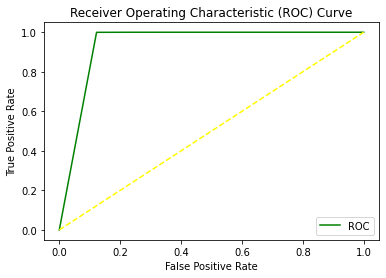

                precision    recall  f1-score   support

    Fraudulent       0.96      0.77      0.85        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.98      0.88      0.93     56962
  weighted avg       1.00      1.00      1.00     56962



0.938721047999954

In [0]:
# Checking AUC 

clf_score(knn_clf)


* The KNN model with imbalanced data gives AUC of 0.94  which is pretty good but recall is 0.77 which is the score we should look to improve in this case.

### Decision Tree

In [0]:
#importing libraries

from sklearn import tree
from pprint import pprint


In [0]:
# 5 fold cross validation for getting best parameter

depth_score=[]
dep_rng = [x for x in range(1,20)]
for i in dep_rng:
  clf = tree.DecisionTreeClassifier(max_depth=i)
  score_tree = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=-1)
  depth_score.append(score_tree.mean())
print(depth_score)

[0.9990783207882552, 0.9992889903223684, 0.9993109350655051, 0.9994338256270711, 0.9994777151133446, 0.9994908819592266, 0.9994250477298163, 0.9994513814215804, 0.9994250477298163, 0.9994118808839343, 0.9993987140380522, 0.9993592135004059, 0.9993065461168777, 0.9993109350655051, 0.9992714345278589, 0.9992714345278587, 0.9992538787333496, 0.9992363229388401, 0.9992099892470758]


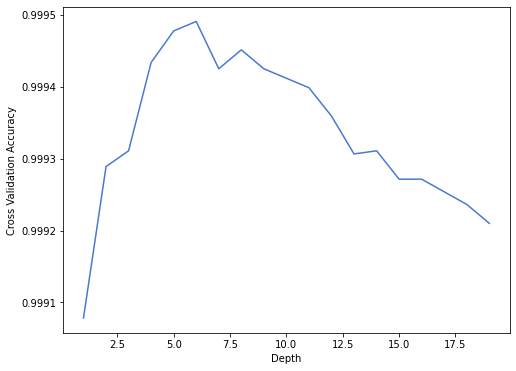

In [0]:
#Plotting depth against score

plt.figure(figsize=(8,6))
sns.lineplot(dep_rng,depth_score,markers=True,dashes=False)
plt.xlabel("Depth")
plt.ylabel("Cross Validation Accuracy")

plt.show()



* The score for depth=5 is the highest. We will use this in our model.




AUC: 0.88


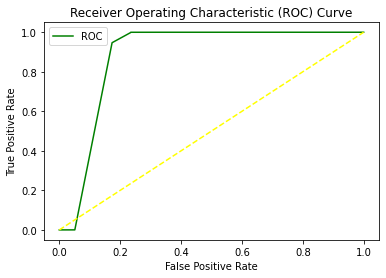

                precision    recall  f1-score   support

    Fraudulent       0.92      0.71      0.80        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.96      0.86      0.90     56962
  weighted avg       1.00      1.00      1.00     56962



0.8828367253626268

In [0]:
#Fitting the model with depth=5 and plotting ROC curve

dt = tree.DecisionTreeClassifier(max_depth = 5)
dt_clf = dt.fit(X_train,y_train)

#Plotting ROC
clf_score(dt_clf)

* The AUC score for decision tree is only 0.88 which is not satisfactory. The precison and recall are also lower than KNN and logistic regression model.

### Random Forest Classifier

In [0]:
#Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [0]:
# Using grid search cv to find the best parameters.

param = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [2, 3, 4, 7, 9]}
rfc = RandomForestClassifier()
clf_rfc_cv = GridSearchCV(rfc, param, cv=5,scoring='roc_auc', n_jobs=-1)
clf_rfc_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_rfc_cv.best_params_)
print("accuracy :",clf_rfc_cv.best_score_)



tuned hpyerparameters :(best parameters)  {'max_depth': 9, 'n_estimators': 50}
accuracy : 0.9779214701077688


* We will use these parameters for Random forest  {'max_depth': 9, 'n_estimators': 30}. The Accuracy is 0.97 which is very good.

AUC: 0.96


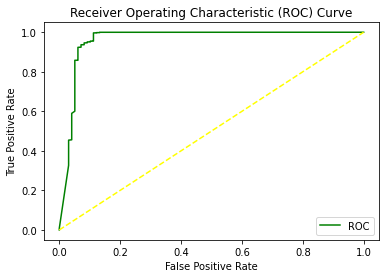

                precision    recall  f1-score   support

    Fraudulent       0.99      0.72      0.84        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.99      0.86      0.92     56962
  weighted avg       1.00      1.00      1.00     56962



0.9603265722439791

In [0]:
#Fitting model and plotting ROC

rf = RandomForestClassifier(max_depth=9, n_estimators=30)
RFC_clf = rf.fit(X_train,y_train)

#Plotting ROC
clf_score(RFC_clf)


* We are getting very good precision(0.97) for Faudulent class which is very good along with the AUC of 0.97

### XGBoost Classifier

In [0]:
#import libraries

from xgboost import XGBClassifier
from scipy import stats

In [0]:
# Using grid search cv to find the best parameters.

xgbst = XGBClassifier()

param_xgb = {'n_estimators': [130,140,150],
              'max_depth': [3, 5, 7],
               'min_child_weight':[1,2,3]
             } 

clf_xgb_cv = GridSearchCV(xgbst, param_xgb, cv=3,scoring='roc_auc', n_jobs=-1)
clf_xgb_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_xgb_cv.best_params_)
print("accuracy :",clf_xgb_cv.best_score_)



tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150}
accuracy : 0.9850958755280601


* We got the best parameters for XGboost as following.

tuned hpyerparameters : {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150}
AUC : 0.9850958755280601

AUC: 0.98


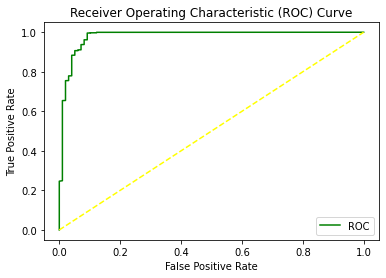

                precision    recall  f1-score   support

    Fraudulent       0.96      0.78      0.86        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.98      0.89      0.93     56962
  weighted avg       1.00      1.00      1.00     56962



0.9798450366359261

In [0]:
#Fitting the model with best parameters.

xgbst = XGBClassifier(n_estimators=150,max_depth=5,min_child_weight=3)

xgb_clf = xgbst.fit(X_train,y_train)

#Plotting ROC
clf_score(xgb_clf)


* We are getting AUC of 0.98 with f1-score of 0.86 which is good.
* Recall is 0.78 which is better than our other models.

#### Proceed with the model which shows the best result 


* Out of the 5 models XGBoost performed the best with AUC of 0.98 and Recall of 0.78.

AUC: 0.98


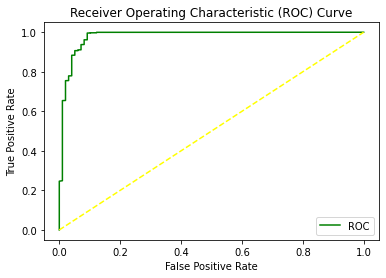

                precision    recall  f1-score   support

    Fraudulent       0.96      0.78      0.86        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.98      0.89      0.93     56962
  weighted avg       1.00      1.00      1.00     56962



0.9798450366359261

In [0]:
clf = XGBClassifier(n_estimators=150,max_depth=5,min_child_weight=3)  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)

# print the evaluation score on the X_test by choosing the best evaluation metric
clf_score(clf)

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 17
2nd Top var = 14
3rd Top var = 10


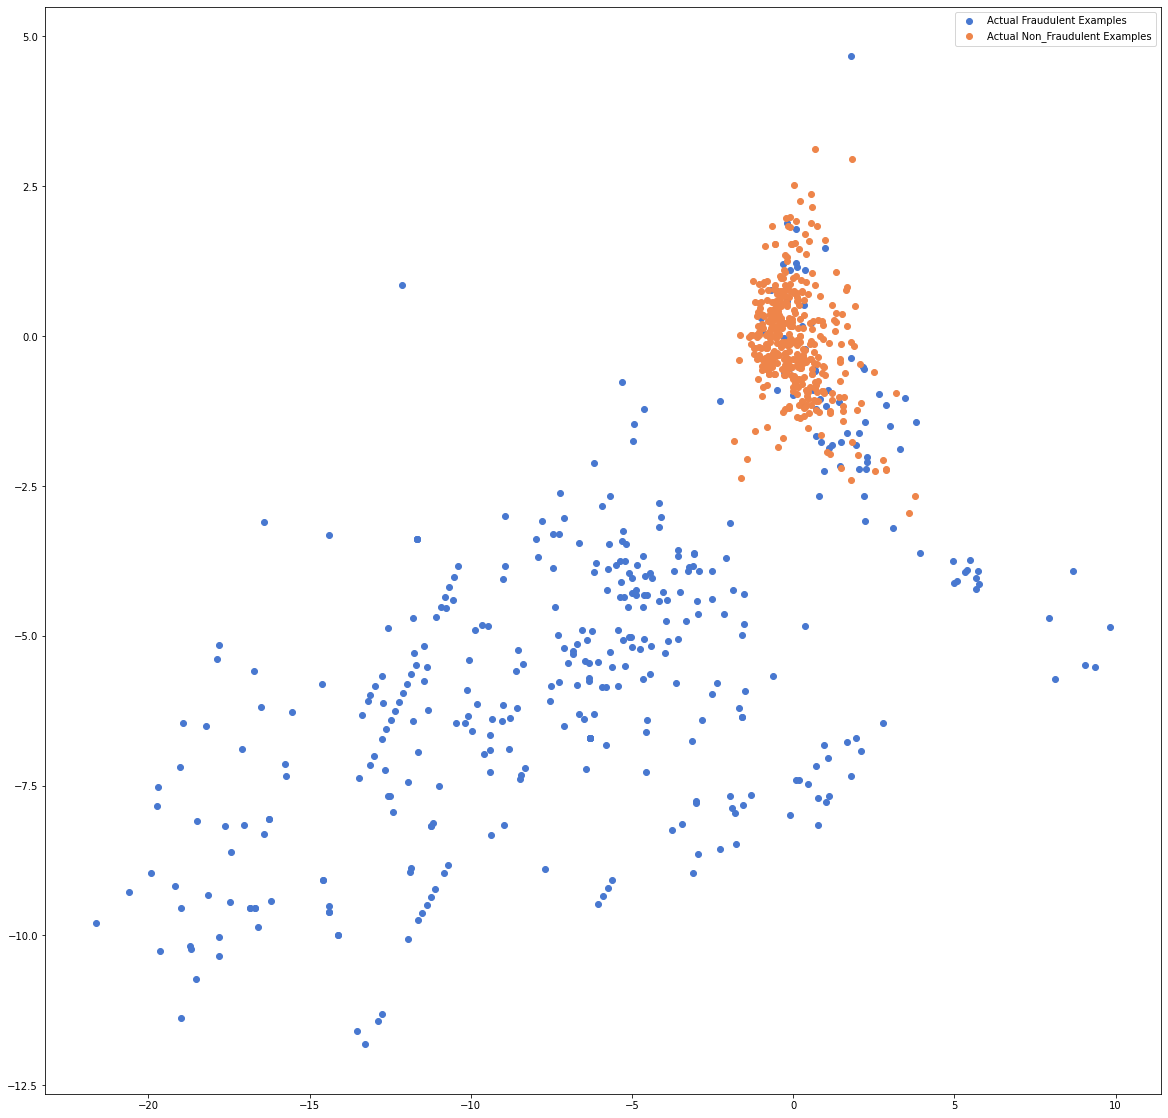

In [0]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-17 and Index-14 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train.values=='Fraudulent')]
X_train_0 = X_train.to_numpy()[np.where(y_train.values=='Non_Fraudulent')]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Fraudulent Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Non_Fraudulent Examples')
plt.legend()
plt.show()

## Handling Class Imbalance

* We will use two balancing techniques, SMOTE & ADASYN.
* In SMOTE a subset of data is taken from the minority class as an example and then new synthetic similar instances are created.
* ADASYN (Adaptive Synthetic) is an algorithm that generates synthetic data, and its greatest advantages are not copying the same minority data, and generating more data for “harder to learn” examples.



#### Class balancing with **SMOTE**:

In [21]:
#importing SMOTE

from imblearn.over_sampling import SMOTE

sm = SMOTE(kind = "regular")
X_sm, y_sm = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [22]:
#CHecking shape and class count after smote
from collections import Counter

print('Resampled dataset shape %s' % Counter(y_sm))
print(X_sm.shape)
print(y_sm.shape)

Resampled dataset shape Counter({'Non_Fraudulent': 227451, 'Fraudulent': 227451})
(454902, 29)
(454902,)


* As seen above the count of each class is same after SMOTE resampling.

#### Class balancing with **ADASYN**:

In [23]:
# importing ADASYN

from imblearn.over_sampling import ADASYN

ada = ADASYN()
X_ada, y_ada = ada.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [24]:
# CHecking shape and class count after ADASYN
from collections import Counter

print('Resampled dataset shape %s' % Counter(y_ada))
print(X_ada.shape)
print(y_ada.shape)

Resampled dataset shape Counter({'Fraudulent': 227474, 'Non_Fraudulent': 227451})
(454925, 29)
(454925,)


### Print the class distribution after applying SMOTE 

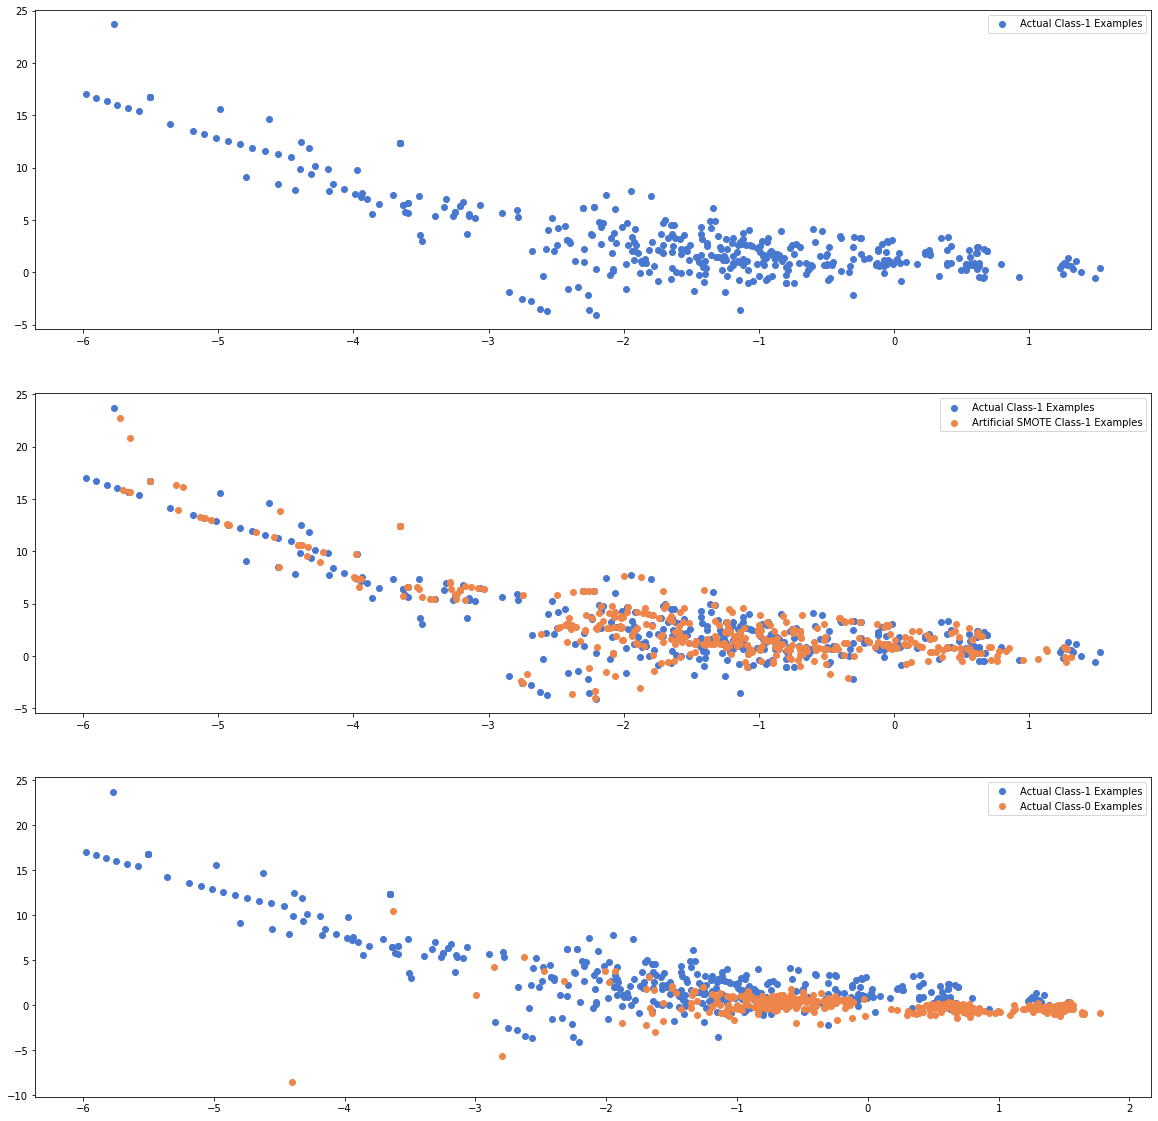

In [0]:
from imblearn import over_sampling
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=0)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train.values=='Fraudulent')]
X_train_0 = X_train.to_numpy()[np.where(y_train.values=='Non_Fraudulent')]


plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
            label='Artificial SMOTE Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

### Print the class distribution after applying ADASYN

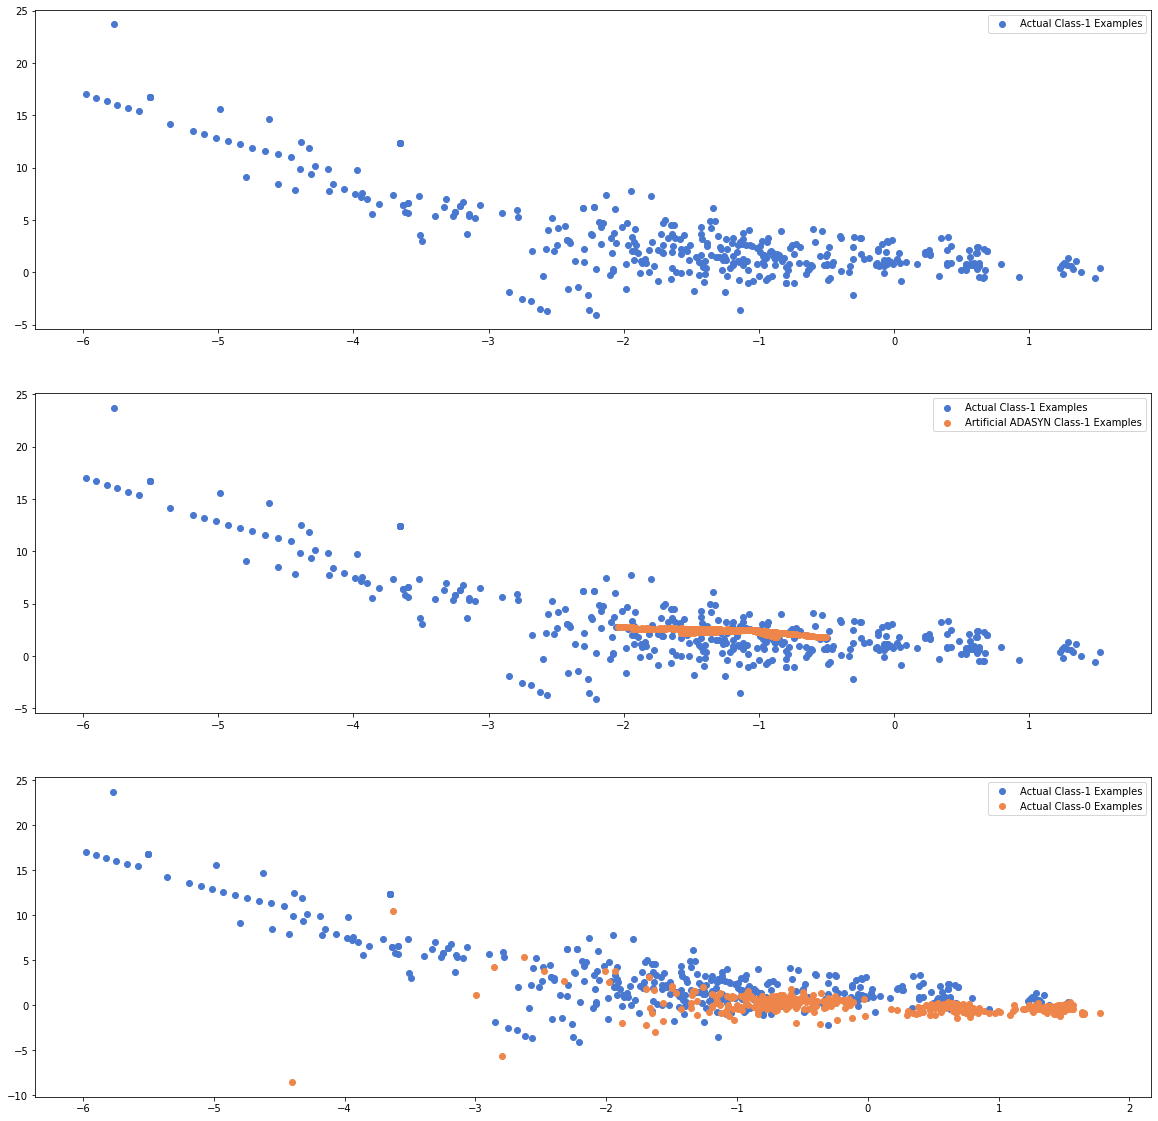

In [0]:
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train.values=='Fraudulent')]
X_train_0 = X_train.to_numpy()[np.where(y_train.values=='Non_Fraudulent')]



import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
            label='Artificial ADASYN Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

## Model Building with Balanced data
- We will use our tuned models which was built on imbalanced data, with both SMOTE and ADASYN technique and see which one gives the best result.

### Logistic Regression

#### Logistic regression with SMOTE

AUC: 0.98


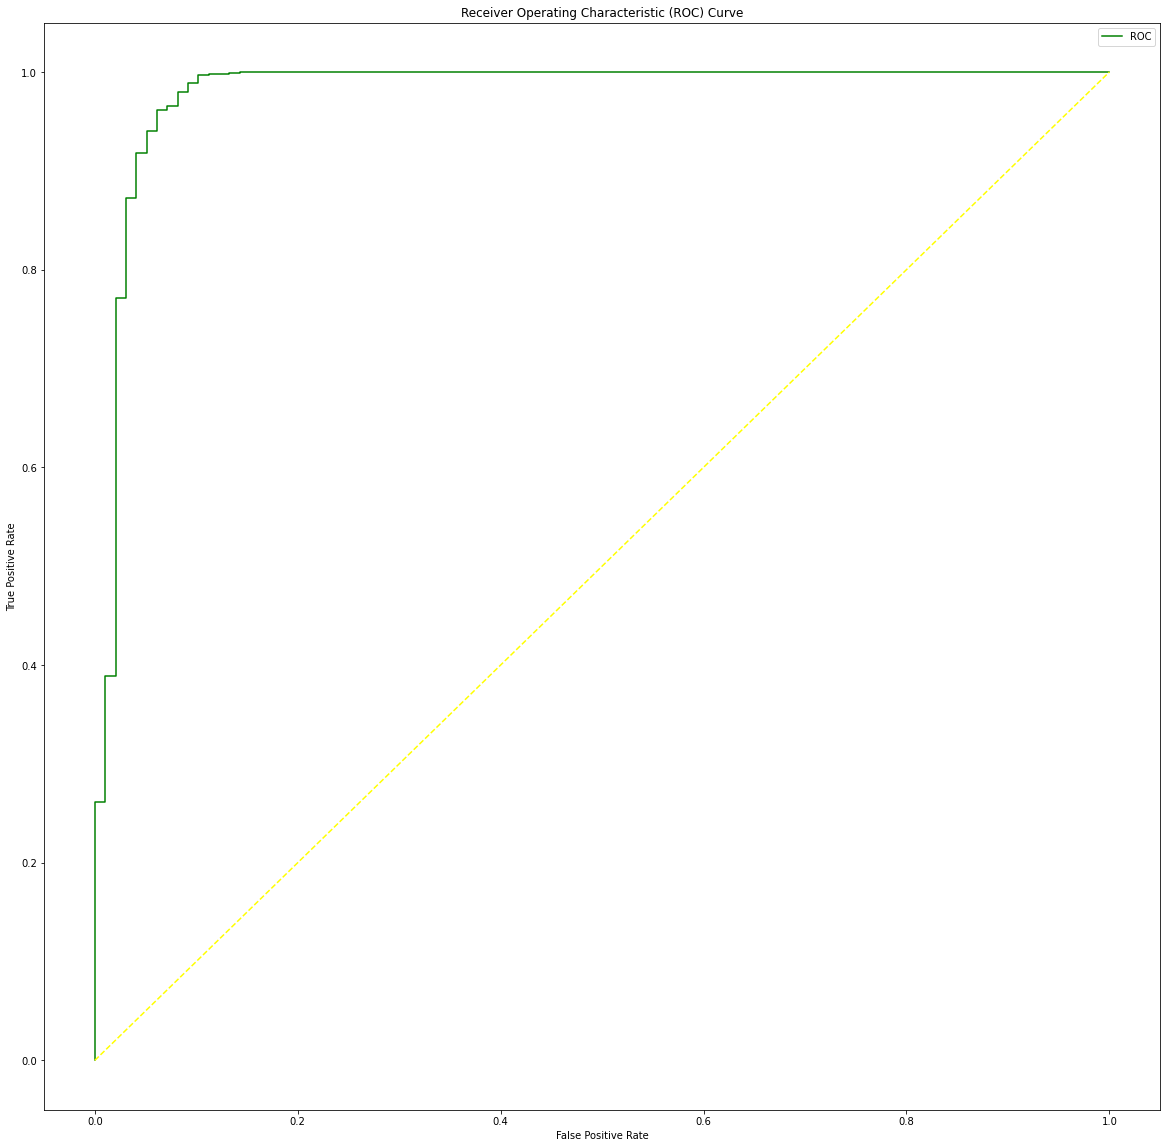

                precision    recall  f1-score   support

    Fraudulent       0.05      0.92      0.10        98
Non_Fraudulent       1.00      0.97      0.99     56864

      accuracy                           0.97     56962
     macro avg       0.53      0.95      0.54     56962
  weighted avg       1.00      0.97      0.98     56962



0.979909996497192

In [0]:
# Using the best parameters that we got from the cross validation on imbalanced data.

lsr_best = LogisticRegression(penalty='l2',C=0.01,random_state = 0)
lsr_sm = lsr_best.fit(X_sm,y_sm)

# Printing ROC curve and accuracy scores
clf_score(lsr_sm)

#### Logistic regression with ADASYN

AUC: 0.98


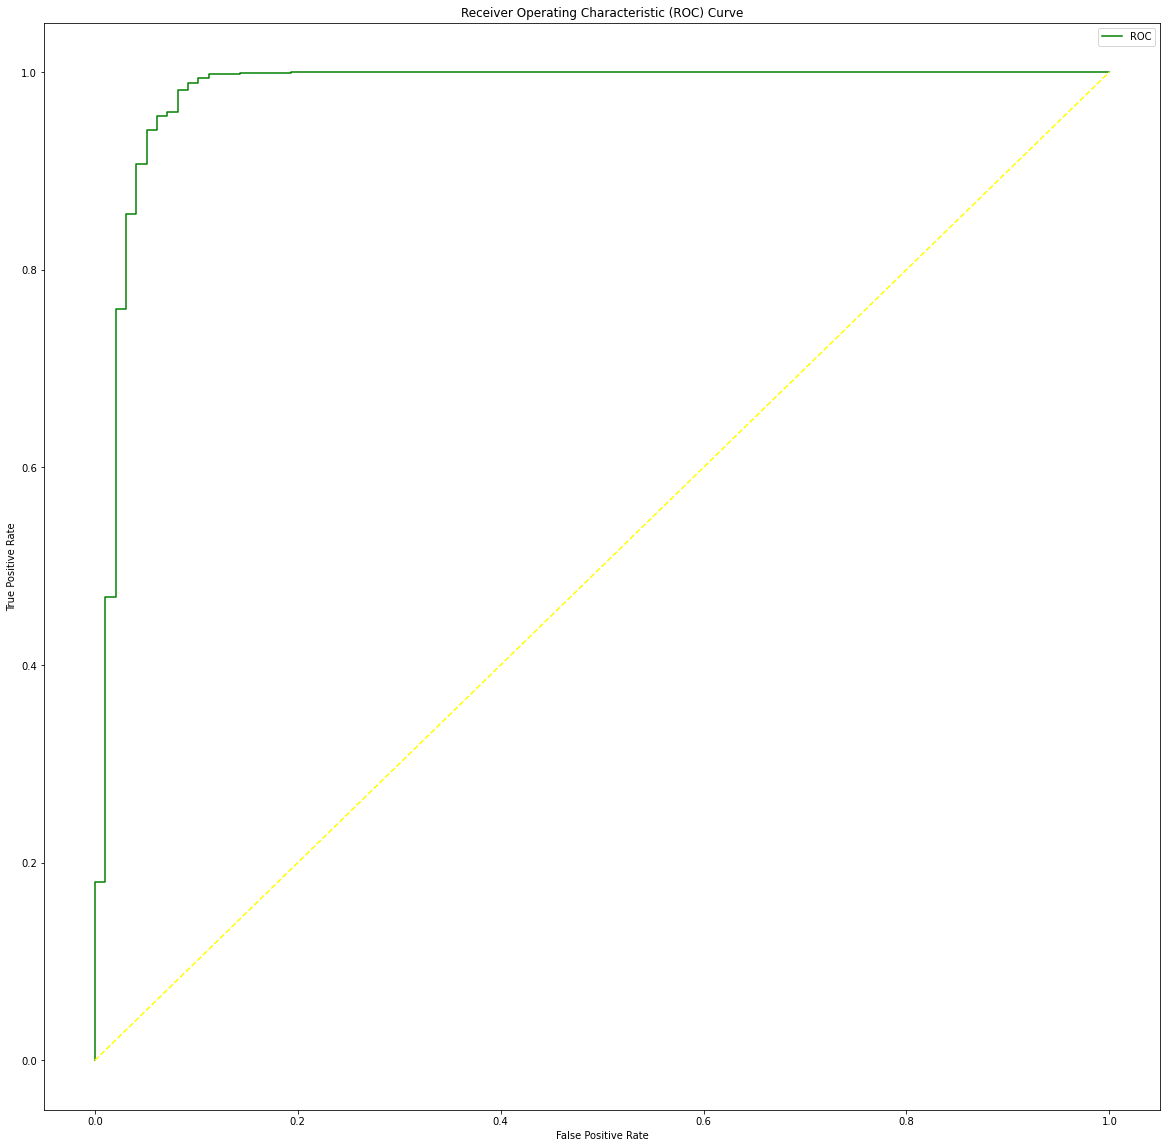

                precision    recall  f1-score   support

    Fraudulent       0.02      0.95      0.03        98
Non_Fraudulent       1.00      0.91      0.95     56864

      accuracy                           0.91     56962
     macro avg       0.51      0.93      0.49     56962
  weighted avg       1.00      0.91      0.95     56962



0.9793364834678949

In [0]:
lsr_ada = lsr_best.fit(X_ada,y_ada)

# Printing ROC curve and accuracy scores
clf_score(lsr_ada)

- AUC & Recall both are better on SMOTE. 
- But the f1-score is extremely low. Model is overfitting.

### K-Nearest Neighbours

#### KNN on SMOTE

AUC: 0.94


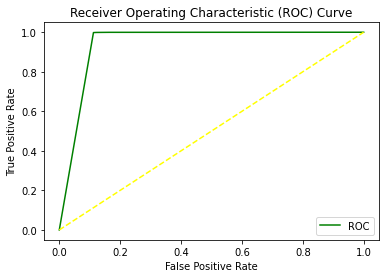

                precision    recall  f1-score   support

    Fraudulent       0.61      0.88      0.72        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.80      0.94      0.86     56962
  weighted avg       1.00      1.00      1.00     56962



0.9435731189633987

In [0]:
# KNN with SMOTE re-sampled data

knn = KNeighborsClassifier(n_neighbors=3)

knn_sm = knn.fit(X_sm,y_sm)

#Printing ROC 

clf_score(knn_sm)

#### KNN on ADASYN

AUC: 0.94


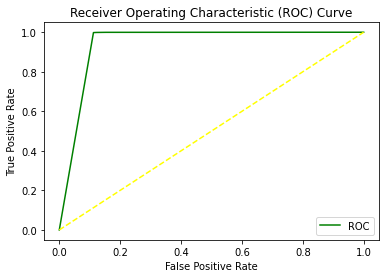

                precision    recall  f1-score   support

    Fraudulent       0.60      0.88      0.71        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.80      0.94      0.86     56962
  weighted avg       1.00      1.00      1.00     56962



0.9435653130132188

In [25]:
# KNN with ADASYN re-sampled data

knn = KNeighborsClassifier(n_neighbors=3)

knn_ada = knn.fit(X_ada,y_ada)

#Printing ROC 

clf_score(knn_ada)

- KNN gives same recall(0.88) on both SMOTE and ADASYN.
- But on SMOTE, the AUC & f1-score are slightly better. So, KNN performs better on SMOTE. 


### Decision Tree Classifier



#### Decision Tree on Smote

AUC: 0.95


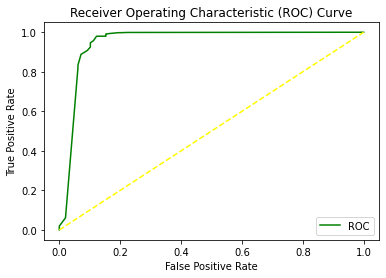

                precision    recall  f1-score   support

    Fraudulent       0.03      0.90      0.05        98
Non_Fraudulent       1.00      0.95      0.97     56864

      accuracy                           0.95     56962
     macro avg       0.51      0.92      0.51     56962
  weighted avg       1.00      0.95      0.97     56962



0.951117255779633

In [26]:
# Building model with SMOTE

dt = tree.DecisionTreeClassifier(max_depth = 5)
dt_sm = dt.fit(X_sm,y_sm)

#Plotting ROC
clf_score(dt_sm)

#### Decision Tree on Adasyn

AUC: 0.95


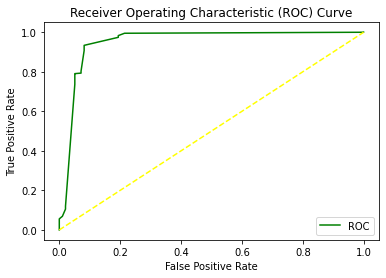

                precision    recall  f1-score   support

    Fraudulent       0.02      0.92      0.03        98
Non_Fraudulent       1.00      0.91      0.95     56864

      accuracy                           0.91     56962
     macro avg       0.51      0.92      0.49     56962
  weighted avg       1.00      0.91      0.95     56962



0.9504922414238626

In [0]:
# Building model with ADASYN

dt = tree.DecisionTreeClassifier(max_depth = 5)
dt_ada = dt.fit(X_ada,y_ada)

#Plotting ROC
clf_score(dt_ada)

- AUC is higher in SMOTE by a small margin but Recall is better in ADASYN than SMOTE.
- The Precision is extremely low in both, resulting in low f1-score. So the model is not good enough.

### Random Forest Classifier

#### Random Forest on SMOTE 

AUC: 0.98


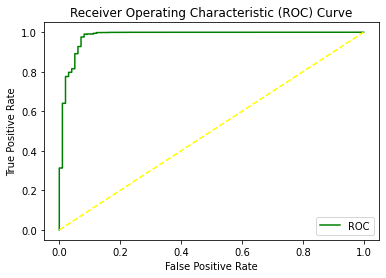

                precision    recall  f1-score   support

    Fraudulent       0.42      0.88      0.57        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.71      0.94      0.78     56962
  weighted avg       1.00      1.00      1.00     56962



0.9805216420417351

In [0]:
#Building Random forest with best parameters on SMOTE
rf = RandomForestClassifier(max_depth=9, n_estimators=30)
RFC_sm = rf.fit(X_sm,y_sm)

#Plotting ROC
clf_score(RFC_sm)


#### Random Forest on ADASYN 

AUC: 0.98


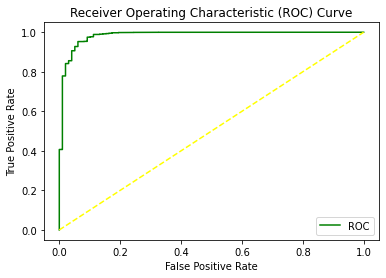

                precision    recall  f1-score   support

    Fraudulent       0.07      0.89      0.13        98
Non_Fraudulent       1.00      0.98      0.99     56864

      accuracy                           0.98     56962
     macro avg       0.53      0.93      0.56     56962
  weighted avg       1.00      0.98      0.99     56962



0.9842775602081013

In [0]:
#Building Random forest with best parameters on ADASYN
rf = RandomForestClassifier(max_depth=9, n_estimators=30)
RFC_ada = rf.fit(X_ada,y_ada)

#Plotting ROC
clf_score(RFC_ada)


- Random Forest performs better on SMOTE.
- Both AUC and Recall for Fraud transactions are better on ADASYN sampled data, but Precision is extremely low.
- Where as in SMOTE we have a fair precision with good recall resulting in a fair f1-score(0.57). 

### XGBoost Classifier

#### XGBoost with SMOTE

In [0]:
# Since X_sm and X_ada are arrays, we need to covert them to dataframes to avoid feature mismatch error 
X_sm = pd.DataFrame(X_sm)
X_sm.columns = cols

X_ada = pd.DataFrame(X_ada)
X_ada.columns = cols

AUC: 0.98


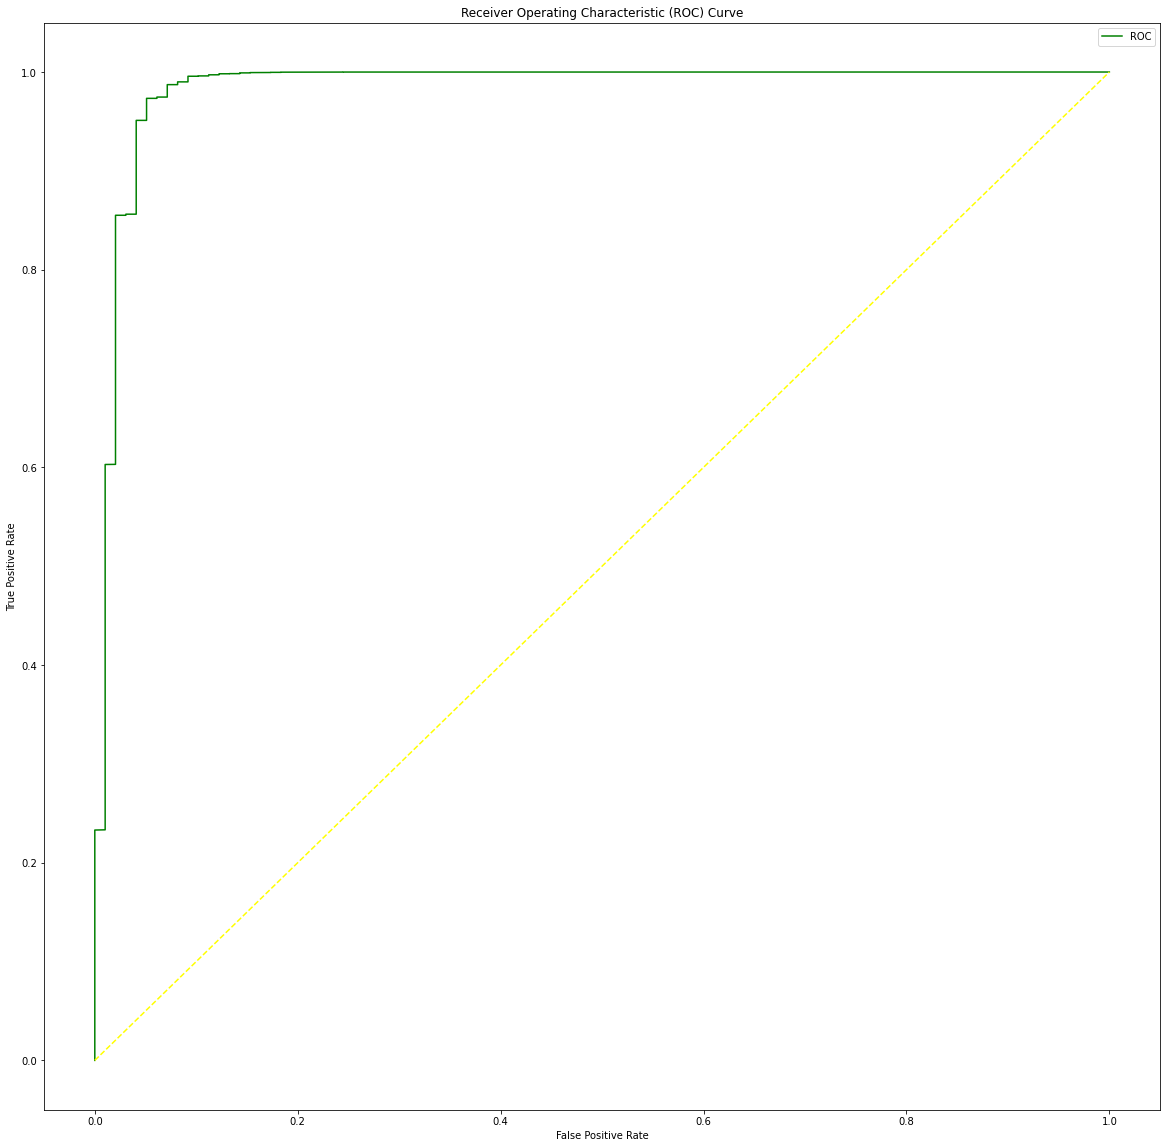

                precision    recall  f1-score   support

    Fraudulent       0.31      0.89      0.46        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.66      0.94      0.73     56962
  weighted avg       1.00      1.00      1.00     56962



0.9837315923133462

In [0]:
#Fitting the XGBoost model with best parameters on SMOTE

xgbst = XGBClassifier(n_estimators=150,max_depth=5,min_child_weight=3)

xgb_sm = xgbst.fit(X_sm,y_sm)

#Plotting ROC
clf_score(xgb_sm)

#### XGBoost with ADASYN

AUC: 0.98


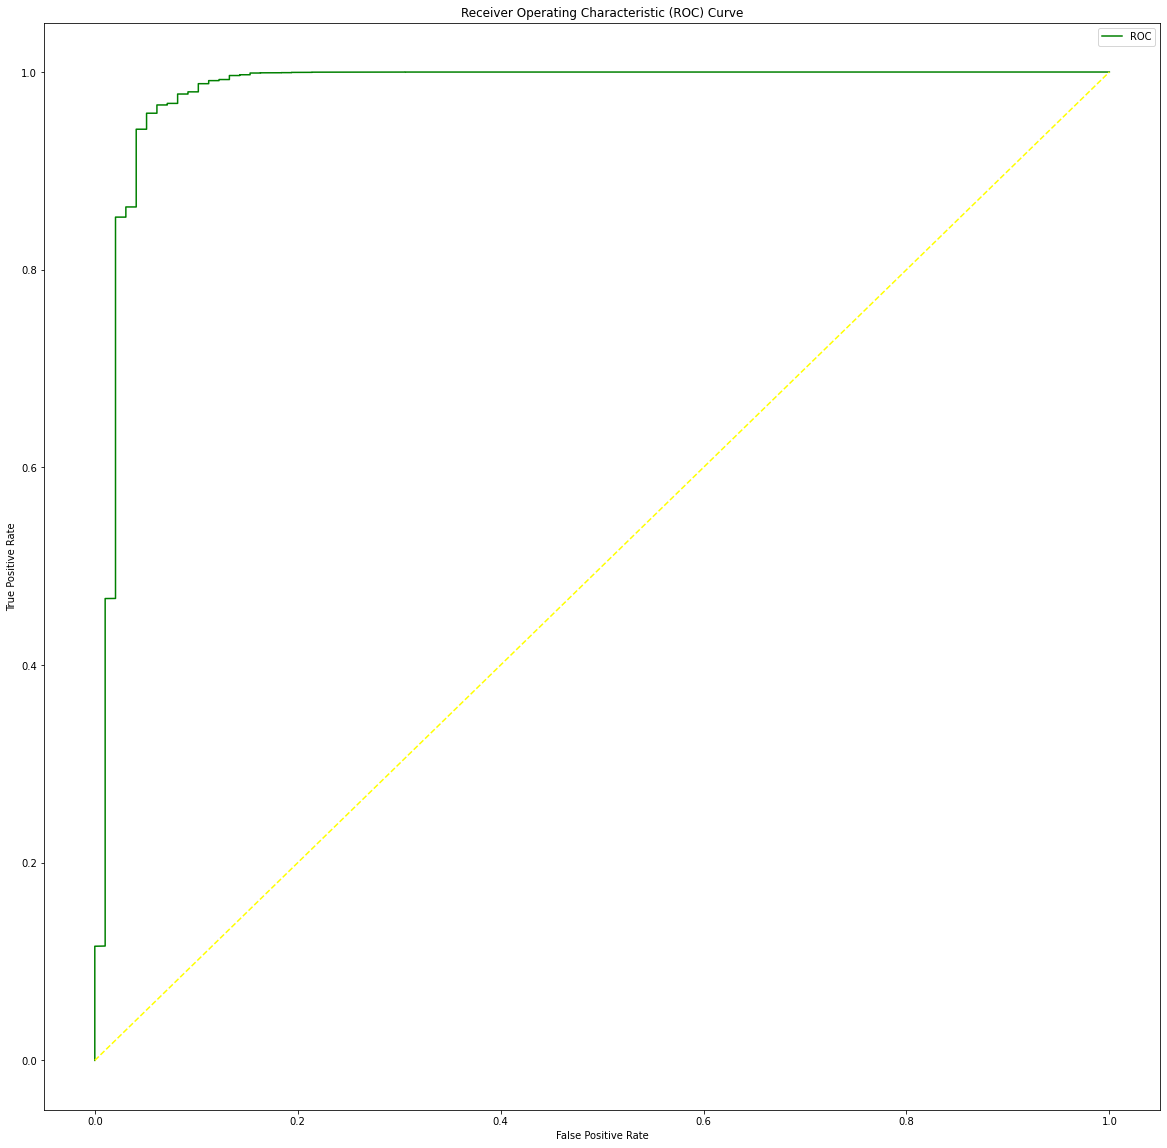

                precision    recall  f1-score   support

    Fraudulent       0.20      0.87      0.33        98
Non_Fraudulent       1.00      0.99      1.00     56864

      accuracy                           0.99     56962
     macro avg       0.60      0.93      0.66     56962
  weighted avg       1.00      0.99      1.00     56962



0.9801282939315287

In [0]:
#Fitting the XGBoost model with best parameters on ADASYN

xgbst = XGBClassifier(n_estimators=150,max_depth=5,min_child_weight=3)

xgb_ada = xgbst.fit(X_ada,y_ada)

#Plotting ROC
clf_score(xgb_ada)

*  AUC is similar in both resampled data scenarios. 
* With SMOTE XGBoost gives a better Recall but both have a low precision & f1-score.

## Choosing the Best Model.

- To save banks from high-value fraudulent transactions, we have to focus on a high recall in order to detect actual fraudulent transactions but we can not have a very low precision.

- The top two models giving better AUC are KNN (with SMOTE) & Random Forest(with SMOTE).

- Scores of Random Forest model:

          AUC : 0.98 

          Recall: 0.88

          Precision: 0.42

          f1-Score : 0.57

- Scores of KNN model:

          AUC : 0.94 

          Recall: 0.88

          Precision: 0.61

          f1-Score : 0.72

- Comparing both we can see that the Random forest model has more AUC score than KNN but the KNN model has a better f1-score (Which is a result of better precision and recall)

- Though the recall is same in both, having a better precision at a little trade off with AUC score will help the model generalize better. Having a good precision will help preventing a fair transaction being called fraudaulent.

- So the KNN model with SMOTE oversampling is our final model.

AUC: 0.94


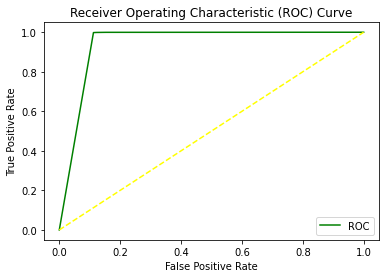

                precision    recall  f1-score   support

    Fraudulent       0.60      0.88      0.71        98
Non_Fraudulent       1.00      1.00      1.00     56864

      accuracy                           1.00     56962
     macro avg       0.80      0.94      0.86     56962
  weighted avg       1.00      1.00      1.00     56962



0.9435653130132188

In [27]:
# perform the best oversampling method on X_train & y_train

clf = KNeighborsClassifier(n_neighbors=3)  #initialise the model with optimum hyperparameters
clf.fit(X_sm, y_sm ) # fit on the balanced dataset

clf_score(clf)

In [0]:
#Predicting on final KNN model
prb = clf.predict_proba(X_test)
prb = prb[:, 1]



In [29]:
#### Print the FPR,TPR & select the best threshold from the roc curve
print('Train auc =', metrics.roc_auc_score(y_test, prb))
fpr, tpr, thresholds = metrics.roc_curve(y_test,prb, pos_label='Non_Fraudulent')
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)

Train auc = 0.9435653130132188
1.0


### Print the important features of the best model to understand the dataset

- Since feature_importances_ attribute is not available in KNN we can not plot the important features. We will use our 2nd best model Random Forest to print important features. 

In [0]:
# Random Forest with SMOTE

rf = RandomForestClassifier(max_depth=9, n_estimators=30)
clf1 = rf.fit(X_sm,y_sm)

Top var = 14
2nd Top var = 10
3rd Top var = 11


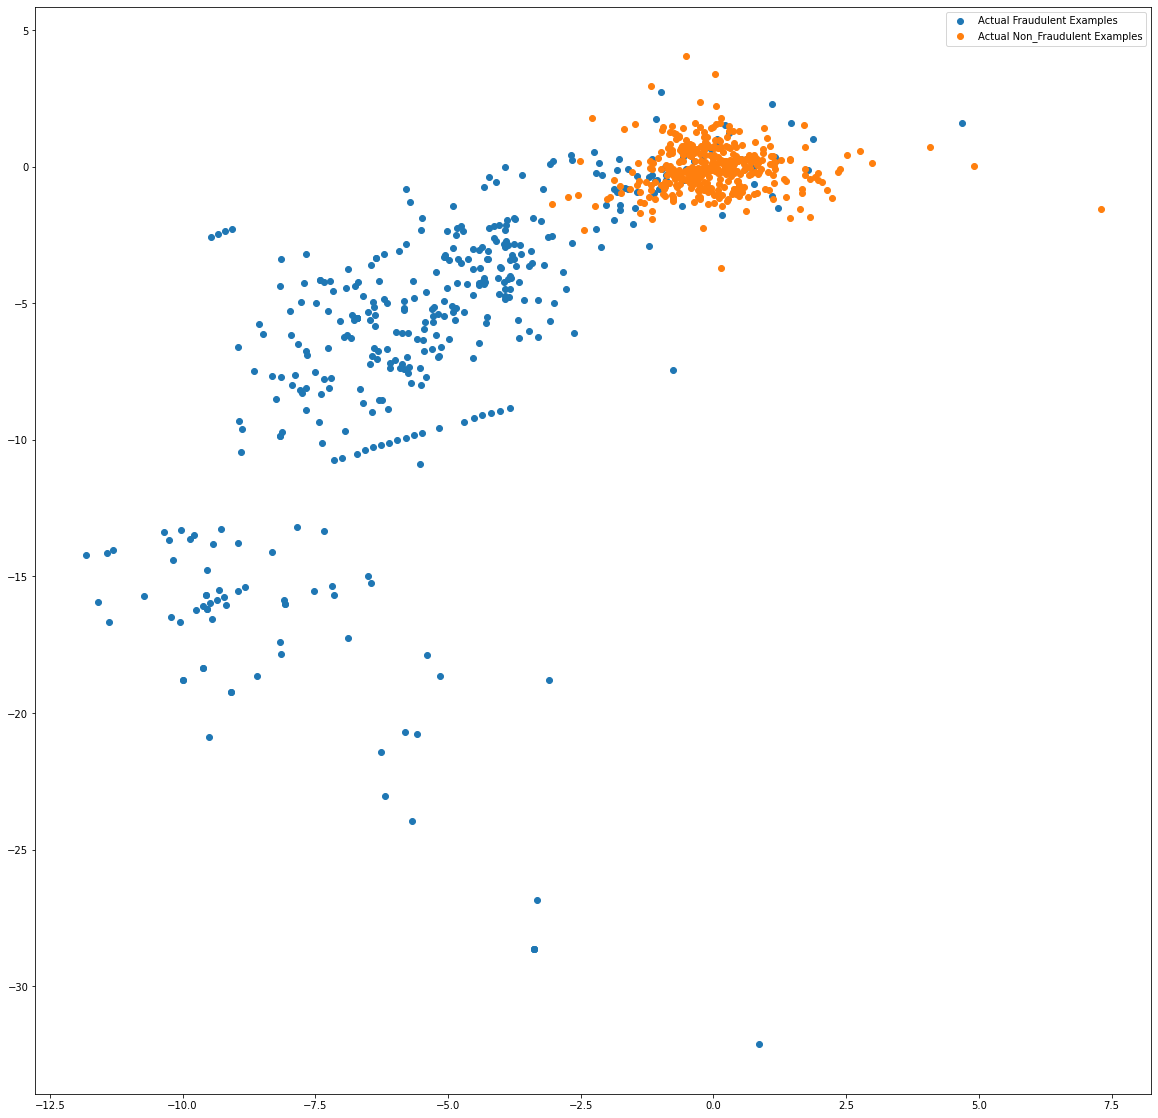

In [31]:
var_imp = []
for i in clf1.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf1.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf1.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf1.feature_importances_)[-3])+1)

# Variable on Index-14 and Index-10 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf1.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf1.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train.values=='Fraudulent')]
X_train_0 = X_train.to_numpy()[np.where(y_train.values=='Non_Fraudulent')]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Fraudulent Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Non_Fraudulent Examples')
plt.legend()